In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def preprocess_dataframe(dataframe):
    dataframe = dataframe[0].str.split(' ', expand=True)
    dataframe.columns = ['music_id', 'image_id', 'matching']
    dataframe['matching'] = dataframe['matching'].astype(float)
    dataframe = dataframe.where(dataframe['matching'] > 0.5).dropna()
    dataframe = dataframe.where(dataframe['image_id'].str.contains('COCO')).dropna()
    dataframe = dataframe.reset_index(drop=True)
    return dataframe

train_data = preprocess_dataframe(pd.read_csv('data/train_matching.txt', sep='\t', header=None))
val_data = preprocess_dataframe(pd.read_csv('data/val_matching.txt', sep='\t', header=None))
test_data = preprocess_dataframe(pd.read_csv('data/test_matching.txt', sep='\t', header=None))

print(f'Train data: {len(train_data)}\nValidation data: {len(val_data)}\nTest data: {len(test_data)}')

Train data: 29696
Validation data: 2273
Test data: 7249


Similarity: 0.9547964877805931


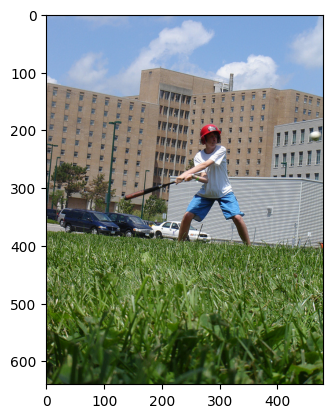

In [3]:
import IPython.display as ipd

def show_music_image(index):
    music_id = train_data.iloc[index]['music_id']
    image_id = train_data.iloc[index]['image_id']
    music_path = 'data/music/' + music_id + '.wav'
    image_path = 'data/images/' + image_id + '.jpg'

    music = ipd.Audio(music_path)
    image = plt.imread(image_path) 

    print(f'Similarity: {train_data.iloc[index]["matching"]}')
    ipd.display(music)
    plt.imshow(image)

index = np.random.randint(0, len(train_data))
show_music_image(index)

In [16]:
import torch
import librosa
from torch.utils.data import Dataset, DataLoader

IMAGE_PATH = 'data/images/'
MUSIC_PATH = 'data/music/'

class MusicImageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self._load()

    def _load(self):
        self.data = []
        pbar = tqdm(self.dataframe.iterrows(), total=len(self.dataframe), desc='Loading data')
        for _, row in pbar:
            music_id = row['music_id']
            image_id = row['image_id']
            music_path = MUSIC_PATH + music_id + '.wav'
            image_path = IMAGE_PATH + image_id + '.jpg'
            music, sr = librosa.load(music_path)
            image = plt.imread(image_path) 
            # TODO: reshape image, somehow handle music
            self.data.append((music, image))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [ ]:
BATCH_SIZE = 32

train_dataset = MusicImageDataset(train_data)
val_dataset = MusicImageDataset(val_data)
test_dataset = MusicImageDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
import torch
import torch.nn as nn

class Music2ImageGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, x):
        pass


class FakeImageDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(512, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Music2ImageGenerator().to(device)
discriminator = FakeImageDiscriminator().to(device)

In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)
criterion = nn.BCELoss()

real_label = torch.FloatTensor(BATCH_SIZE).uniform_(0.9, 1).to(device)
fake_label = torch.FloatTensor(BATCH_SIZE).uniform_(0, 0.1).to(device)

In [ ]:
def train(epoch, train_loader, generator, discriminator, optimizer_G, optimizer_D, criterion):
    generator.train()
    discriminator.train()
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')

    G_losses = []
    D_losses = []

    D_accuracies = []

    for music, image in pbar:

        music = music.to(device)
        image = image.to(device)

        # Train discriminator on real images
        optimizer_D.zero_grad()
        D_real_output = discriminator(image)
        D_real_loss = criterion(D_real_output, real_label)

        # Train discriminator on fake images
        noise = torch.randn(BATCH_SIZE, dim).to(device) # dim - image dimension
        fake_images = generator(noise, music)
        D_fake_output = discriminator(fake_images.detach()) # detach to avoid training generator
        D_fake_loss = criterion(D_fake_output, fake_label)
        
        discriminator_loss = D_real_loss + D_fake_loss
        D_losses.append(discriminator_loss.item())

        D_accuracy = np.mean(D_real_output.cpu().detach().numpy() > 0.5)  
        D_accuracies.append(D_accuracy)

        discriminator_loss.backward()
        optimizer_D.step()
        
        # Train generator
        optimizer_G.zero_grad()
        D_fake_output = discriminator(fake_images)
        G_loss = criterion(D_fake_output, real_label)
        G_losses.append(G_loss.item())

        G_loss.backward()
        optimizer_G.step()

        pbar.set_postfix(f'\n\tGenerator Loss: {np.mean(G_losses):.5f}\n\tDiscriminator Loss: {np.mean(D_losses):.5f}\n\tDiscriminator Accuracy: {np.mean(D_accuracies):.5f}')

In [ ]:
def evaluate(epoch, val_loader, generator, discriminator, criterion):
    generator.eval()
    discriminator.eval()

    G_losses = []
    D_losses = []

    D_accuracies = []

    pbar = tqdm(val_loader, desc=f'Validation Epoch {epoch}')
    with torch.no_grad():
        for music, image in pbar:

            music = music.to(device)
            image = image.to(device)

            # Evaluate discriminator on real images
            D_real_output = discriminator(image)
            D_real_loss = criterion(D_real_output, real_label)

            # Evaluate discriminator on fake images
            noise = torch.randn(BATCH_SIZE, dim).to(device)
            fake_images = generator(noise, music)
            D_fake_output = discriminator(fake_images.detach())

            D_fake_loss = criterion(D_fake_output, fake_label)

            discriminator_loss = D_real_loss + D_fake_loss
            D_losses.append(discriminator_loss.item())

            D_accuracy = np.mean(D_real_output.cpu().detach().numpy() > 0.5)
            D_accuracies.append(D_accuracy)

            # Evaluate generator
            D_fake_output = discriminator(fake_images)
            G_loss = criterion(D_fake_output, real_label)
            G_losses.append(G_loss.item())

            pbar.set_postfix(f'\n\tGenerator Loss: {np.mean(G_losses):.5f}\n\tDiscriminator Loss: {np.mean(D_losses):.5f}\n\tDiscriminator Accuracy: {np.mean(D_accuracies):.5f}')

    return np.mean(G_losses), np.mean(D_losses)

In [ ]:
EPOCHS = 10
best_val_score = 1e9

for epoch in range(EPOCHS):
    train(epoch, train_loader, generator, discriminator, optimizer_G, optimizer_D, criterion)
    val_score = evaluate(epoch, val_loader, generator, discriminator, criterion)
    if val_score < best_val_score:
        best_val_score = val_score
        torch.save(generator.state_dict(), 'models/best_generator.pth')
        torch.save(discriminator.state_dict(), 'models/best_discriminator.pth')